In [1038]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import copy

### Define a function to learn & set dataset size and range

In [1039]:
def random_function(x):
    return -2 * (x ** 2) + 3

num_data_pts = 500
data_range = [-5, 5]

### Define and train a basic neural net

In [1040]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        # Define layers
        self.fci = nn.Linear(input_size, hidden_sizes[0])
        self.fch = nn.ModuleList()  # Use ModuleList for registering hidden layers
        for i in range(len(hidden_sizes) - 1):
            self.fch.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
        self.fco = nn.Linear(hidden_sizes[-1], output_size)
        self.relu = nn.ReLU()  # ReLU activation

    def forward(self, x):
        # Define forward pass
        out = self.fci(x)
        out = self.relu(out)
        for fch in self.fch:
            out = fch(out)
            out = self.relu(out)
        out = self.fco(out)  # Linear output (no activation for regression)
        return out


# Define the model, loss function, and optimizer
input_size = 1
hidden_sizes = [5, 5, 5, 5]
output_size = 1
learning_rate = 0.0001

model = NeuralNetwork(input_size, hidden_sizes, output_size)

# Loss function: MSE for regression
criterion = nn.MSELoss()

# Optimizer: Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Generate training data
X_sample = ((np.random.rand(num_data_pts) * (data_range[1] - data_range[0])) + data_range[0]).reshape(num_data_pts, 1)
y_sample = random_function(X_sample)

# Convert training data to PyTorch tensors
X = torch.tensor(X_sample, dtype=torch.float32)  # Inputs
y = torch.tensor(y_sample, dtype=torch.float32)  # Outputs (labels)

# Train the network
epochs = 10000
for epoch in range(epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward pass and optimization
    optimizer.zero_grad()  # Zero the gradient buffers
    loss.backward()        # Backpropagate the error
    optimizer.step()       # Update weights

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Test the trained network
with torch.no_grad():  # No need to calculate gradients during testing
    predicted = model(X)

original_model_weights = copy.deepcopy(model.state_dict())

Epoch [1000/10000], Loss: 11.0761
Epoch [2000/10000], Loss: 3.3793
Epoch [3000/10000], Loss: 2.1234
Epoch [4000/10000], Loss: 1.5224
Epoch [5000/10000], Loss: 1.2796
Epoch [6000/10000], Loss: 1.1347
Epoch [7000/10000], Loss: 1.0156
Epoch [8000/10000], Loss: 0.8985
Epoch [9000/10000], Loss: 0.8072
Epoch [10000/10000], Loss: 0.7412


### Plotting predictions on true values

0.7411406636238098


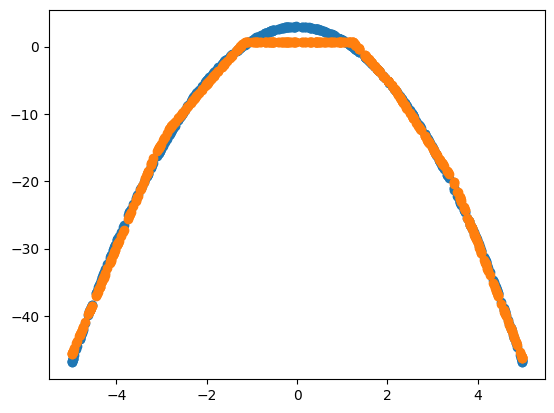

In [1041]:
plt.scatter(X, y)
plt.scatter(X, predicted)
original_loss = criterion(predicted, y).item()
print(original_loss)

## Quantization of neural net using a simple technique

- Reducing the number of unique values in the weights
- Playing around with various uniformly-spaced alphabets

### Visualizing the distribution of weights

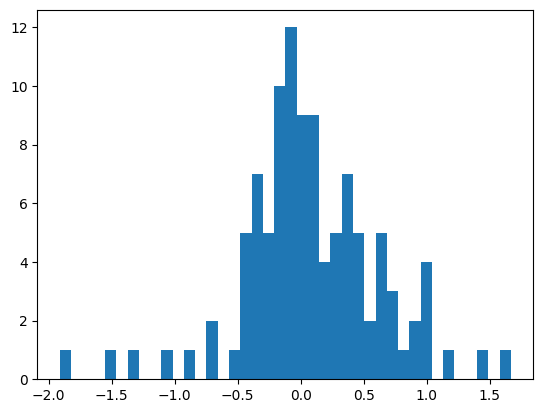

In [1042]:
hist1 = plt.hist(torch.cat([torch.ravel(x) for x in model.state_dict().values()], 0), bins = 40)

### Testing out various scaling parameters 

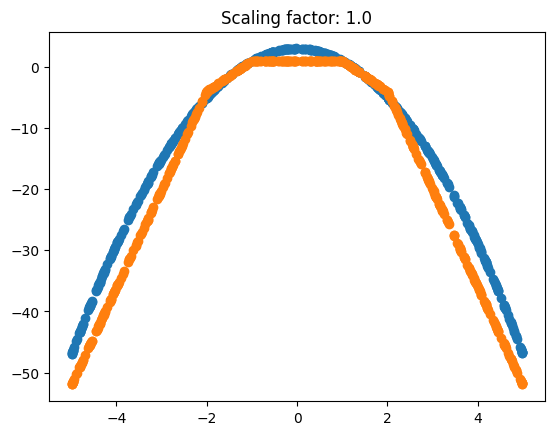

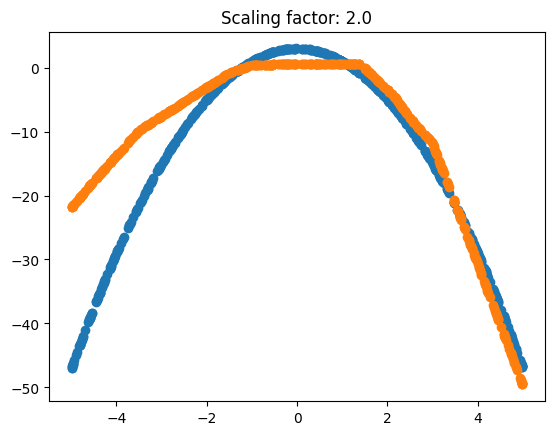

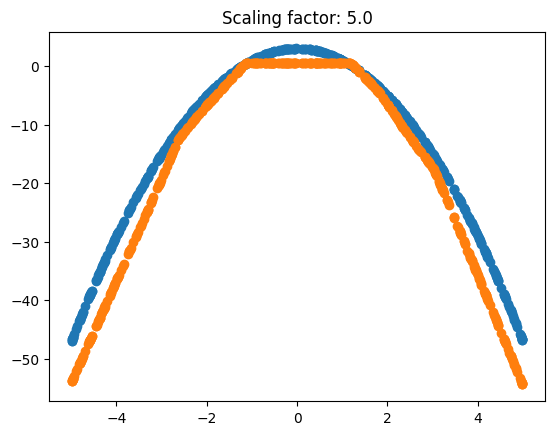

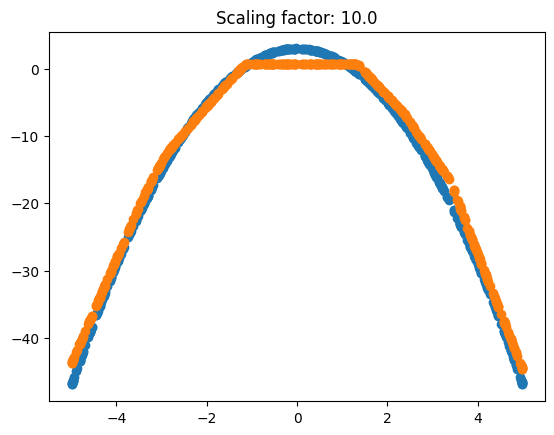

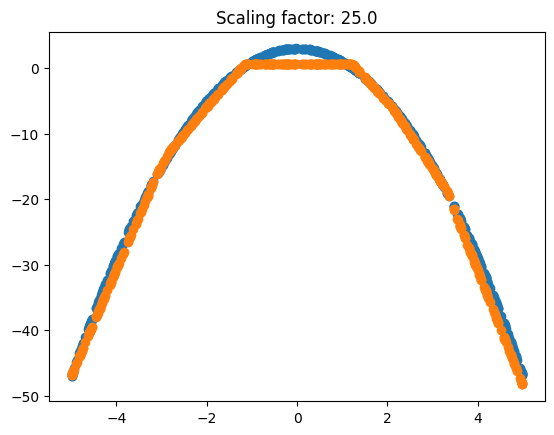

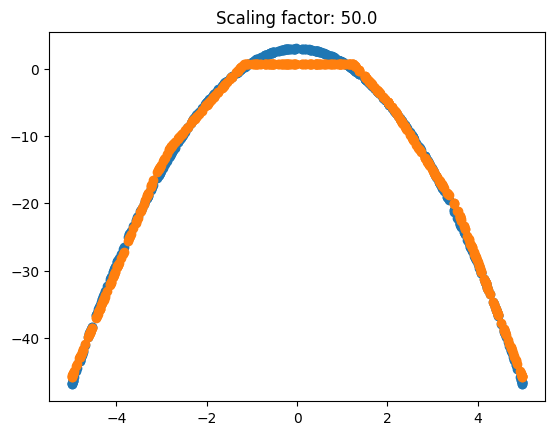

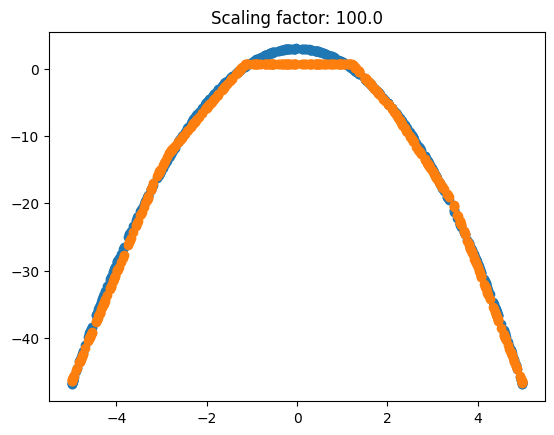

In [1043]:
metrics = dict()

for g in [0, 1, 2, 5, 10, 25, 50, 100]:
    if g == 0:
        continue
    
    g = 1.0 * g
    
    temp = copy.deepcopy(original_model_weights)
    
    for k, v in model.state_dict().items():
        temp[k] = temp[k].apply_(lambda x: round(x * g) / g)

    model.load_state_dict(temp)

    with torch.no_grad():
        predicted_quant = model(X)

    plt.figure(g)
    plt.scatter(X, y)
    plt.scatter(X, predicted_quant)
    plt.title(f"Scaling factor: {g}")
    size = np.float64(torch.log2(torch.tensor(list(torch.cat([torch.ravel(x) for x in model.state_dict().values()], 0).unique().size())))[0])
    loss = criterion(predicted_quant, y).item()
    metrics[g] = [size, loss]

### Visualizing the loss vs. compression for our algorithm

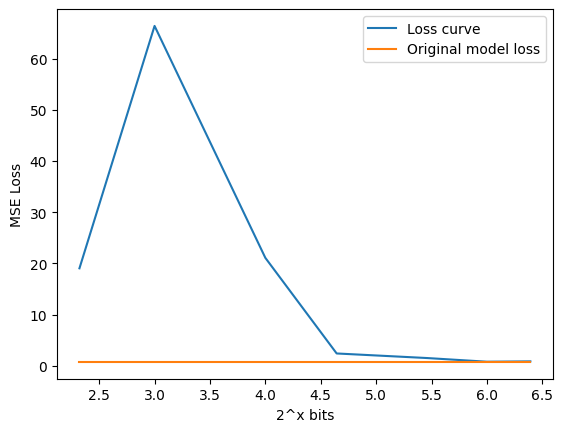

In [1044]:
metrics_data = np.array(list(metrics.values()))
plt.plot(metrics_data[:, 0], metrics_data[:, 1])
plt.plot(metrics_data[:, 0], [original_loss] * metrics_data.shape[0])
plt.xlabel("2^x bits")
plt.ylabel("MSE Loss")
plt.legend(["Loss curve", "Original model loss"])

## Symmetric Layer-by-Layer Quantization (Low-Precision)

### Defining the quantizer

In [1045]:
class LayerQuantizer:

    dtype = {8: torch.int8, 16: torch.int16, 32: torch.int32, 64: torch.int64}

    def __init__(self, weights, activations, b = 8):
        self.b = b
        self.max = ((2 ** (self.b - 1)) - 1)
        self.weights = weights
        self.activations = activations

        self.quant_weights = {k : None for k, _ in self.weights.items()}
        self.quant_activations = None
        
        self.weight_key = list(filter(lambda x: "weight" in x, list(self.weights.keys())))[0]
        self.bias_key = list(filter(lambda x: "bias" in x, list(self.weights.keys())))[0]
        self.s_w = self.compute_scale_factor(self.weights[self.weight_key])
        self.s_x = self.compute_scale_factor(self.activations)

        self.quantize_layer()

    def compute_scale_factor(self, obj):
        return self.max / torch.max(torch.abs(obj))

    def quantize_layer(self):
        self.quant_weights[self.weight_key] = torch.clamp(torch.round(self.s_w * self.weights[self.weight_key]), -self.max-1, self.max).to(LayerQuantizer.dtype[self.b])
        self.quant_weights[self.bias_key] = torch.clamp(torch.round(self.s_w * self.s_x * self.weights[self.bias_key]), -self.max-1, self.max).to(LayerQuantizer.dtype[self.b])

    def get_quantized_weights(self):
        return self.quant_weights[self.weight_key], self.quant_weights[self.bias_key]

    def get_quantized_weights_dict(self):
        return self.quant_weights

    def quantize_input(self, X):
        return torch.clamp(torch.round(self.s_x * X), -self.max-1, self.max).to(LayerQuantizer.dtype[self.b])

    def dequantize_output(self, y):
        return y / (self.s_w * self.s_x)


### Retrieving layer outputs

In [1046]:
def get_layer_outputs(model, input_data):
    outputs = {}

    def hook_fn(module, input, output):
        outputs[module] = output

    for name, module in model.named_modules():
        module.register_forward_hook(hook_fn)

    model(input_data)

    return outputs

### Quantizing the trained model

In [1047]:
quant_model = copy.deepcopy(model)

precision = 8
sample_size = 50
sample_indices = torch.round((X.shape[0] - 1) * torch.rand(sample_size)).to(torch.int)
input_data = X[sample_indices]
layer_outputs = get_layer_outputs(quant_model, input_data)

Qs = {}
first = True
prev_module = None
for name, module in quant_model.named_modules():
    if isinstance(module, nn.Linear):
        if first:
            activations = input_data
            first = False
            prev_module = module
        else:
            activations = layer_outputs[prev_module]
            prev_module = module
        
        weights = module.state_dict()

        Q = LayerQuantizer(weights, activations, b = precision)
        module.load_state_dict(Q.get_quantized_weights_dict())
        Qs[module] = Q

### Adding hooks to quantize inputs an dequantize outputs after every layer

In [1048]:
import torch
from collections import OrderedDict

def remove_hooks(module):
    if hasattr(module, '_forward_hooks'):
        module._forward_hooks = OrderedDict()
    if hasattr(module, '_backward_hooks'):
        module._backward_hooks = OrderedDict()

for name, module in quant_model.named_modules():
    if isinstance(module, nn.Linear):
        remove_hooks(module)

In [1049]:
def inference_pre_hook(module, inputs):
    inputs = Qs[module].quantize_input(inputs[0]).to(torch.float)
    return inputs
    
def inference_post_hook(module, input, outputs):
    outputs = Qs[module].dequantize_output(outputs).to(torch.float)
    return outputs

In [1050]:
for name, module in quant_model.named_modules():
    if isinstance(module, nn.Linear):
        module.register_forward_pre_hook(inference_pre_hook)
        module.register_forward_hook(inference_post_hook)
    

### Gather model predictions

In [1051]:
# Quantized model
pred_quant = quant_model(X)

In [1052]:
# Original model
pred = model(X)

### Plot quantized model performance

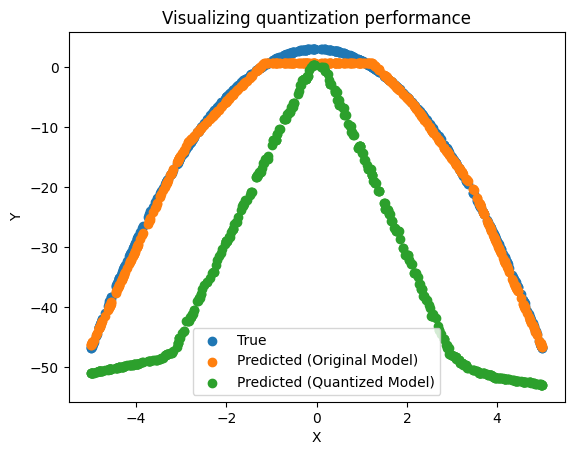

In [1053]:
true = plt.scatter(X, y)
org_plot = plt.scatter(X, pred.detach().numpy())
quant_plot = plt.scatter(X, pred_quant.detach().numpy())
leg = plt.legend(["True", "Predicted (Original Model)", f"Predicted (Quantized Model)"])
title = plt.title("Visualizing quantization performance")
x_lab = plt.xlabel("X")
y_lab = plt.ylabel("Y")